# Directions 

The data is available as two attached CSV files: 
* takehome_user_engagement.csv 
* takehome_users.csv 

The data has the following two tables: 
1. A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes: 
    * name: the user's name 
    * object_id: the user's id 
    * email: email address 
    * creation_source: how their account was created. This takes on one of 5 values: 
        - PERSONAL_PROJECTS: invited to join another user's personal workspace 
        - GUEST_INVITE: invited to an organization as a guest (limited permissions) 
        - ORG_INVITE: invited to an organization (as a full member) 
        - SIGNUP: signed up via the website 
        - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id) 
    * creation_time: when they created their account 
    * last_session_creation_time: unix timestamp of last login 
    * opted_in_to_mailing_list: whether they have opted into receiving marketing emails 
    * enabled_for_marketing_drip: whether they are on the regular marketing email drip 
    * org_id: the organization (group of users) they belong to 
    * invited_by_user_id: which user invited them to join (if applicable).
2. A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption. We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better -- no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

## Load data

In [162]:
import warnings
import pandas as pd
import numpy as np

warnings.simplefilter(action="ignore", category=FutureWarning)

df_user = pd.read_csv('takehome_users.csv', encoding="ISO-8859-1", parse_dates=["creation_time"])
df_login = pd.read_csv('takehome_user_engagement.csv', parse_dates=["time_stamp"])

df_user.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [79]:
df_login.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Data Cleaning

In [80]:
# Convert unix timestamp for last session creation time 
from datetime import datetime
df_user['last_session_creation_time'] = df_user.last_session_creation_time.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') if pd.notnull(x) else np.nan)

### Target Value

We are interested in predicting user adoption; therefore we need to classify those in the data that are considered adopted users which is defined as someone who as logged into the product 3 separate times in at least a 7 day period.

In [164]:
adopt = df_login.set_index("time_stamp")

users = adopt["user_id"].unique()
adoption = []

for i in users:
    id_filter = adopt["user_id"] == i
    df_filter = adopt[id_filter].resample("1D").count()
    df_filter = df_filter.rolling(window=7).sum()
    df_filter = df_filter.dropna()
    adoption.append(any(df_filter["visited"].values >= 3)*1)

In [165]:
user_adoption = list(zip(users, adoption))

df_adopt = pd.DataFrame(user_adoption)
df_adopt.columns = ["user_id", "adopted_user"]

df_adopt.head()

,user_id,adopted_user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


### Merging Data Frames

In [166]:
# Merge df_user and df_adoption to get more insights behind those that adopted/not adopted.
df_user = df_user.rename({"object_id":"user_id"}, axis=1)
df_user = df_user.merge(df_adopt, on = 'user_id', how = 'left')
df_user.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


### Dealing with Missing Values

In [167]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 11 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted_user                  8823 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 1.1+ MB


3 of the columns seem to have null values: last_session_creation_time, adopted_user, and invited_by_user_id.

There seems to be an equal amount of null values for the last_session_creation_time and adopted_user column. Looking further into the values, it seems like these users had created an account but never logged in. Since we already have the login times in a separate dataset, we will drop last_session_creation_time column then fill in the null values in the adopted_user column as 0 since they never logged in. 

In [87]:
df_user[pd.isnull(df_user.last_session_creation_time)].head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN
11,12,2014-04-17 23:48:38,Mathiesen Lærke,LaerkeLMathiesen@cuvox.de,ORG_INVITE,NaN,0,0,130,9270.0,NaN
14,15,2013-07-16 21:33:54,Theiss Ralf,RalfTheiss@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,175,NaN,NaN
15,16,2013-02-11 10:09:50,Engel René,ReneEngel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,211,NaN,NaN


In [168]:
df_user = df_user.drop('last_session_creation_time', axis = 1)
df_user['adopted_user'] = df_user.adopted_user.fillna(0)

For the invited_by_user column, if it is missing a value, that means that the user was not invited to the platform by anyone. Instead, we will convert this column into a 0/1 column in which 0 means  not invited and 1 means invited by another user.

In [169]:
df_user['invited_by_user_id'] = df_user.invited_by_user_id.apply(lambda x: 1 if pd.notnull(x) else 0)
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null int64
adopted_user                  12000 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 1.0+ MB


## Exploratory Analysis

First, we will look at the distribution for adoption rate.

adopted_user
0.0    0.866917
1.0    0.133083
Name: user_id, dtype: float64


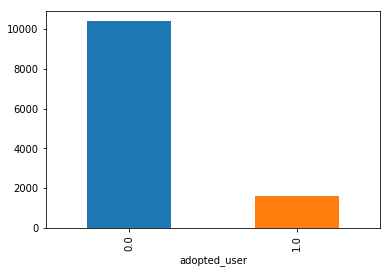

In [191]:
adoption = df_user.groupby('adopted_user').count().user_id
print(adoption/len(df_user))
adoption.plot('bar')
plt.show()

The dataset is extremely biased. Only 13.3% of the users are considered to be adopted users. Therefore, we need to upsample the minority group to create a more accurate model. However, we will give higher weight to the majority group. If we leave the dataset as is, we can predict that none of the users have adopted the app  have a 87% chance of being correct.

In [376]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df_user[df_user.adopted_user == 0]
df_minority = df_user[df_user.adopted_user == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=7500,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.adopted_user.value_counts()

0.0    10403
1.0     7500
Name: adopted_user, dtype: int64

We will concentrate on the following features to build the model that predicts adoption:
* creation_source
* opted_in_to_mailing_list
* enabled_for_marketing_drip
* invited_by_user_id

In [154]:
import matplotlib.pyplot as plt

def freqbars(colname, data, name):
    tm_plot = data.groupby(['adopted_user', colname]).size().reset_index().pivot(columns='adopted_user', index=colname, values=0)
    tm_plot.plot(kind='bar', stacked = False, color = ('navy', 'skyblue'))
    plt.ylabel('Count', fontsize=12)
    plt.xlabel(name, fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title(f"Frequency of {name} Count", fontsize=12)

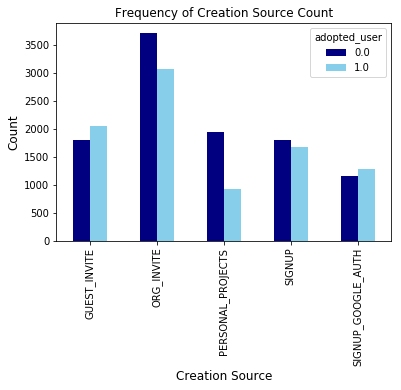

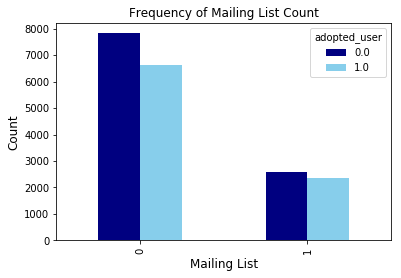

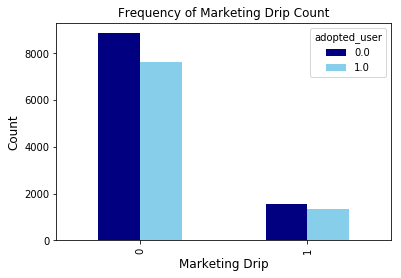

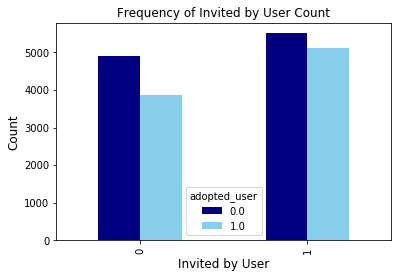

In [211]:
freqbars('creation_source', df_upsampled, 'Creation Source')
freqbars('opted_in_to_mailing_list', df_upsampled, 'Mailing List')
freqbars('enabled_for_marketing_drip', df_upsampled, 'Marketing Drip')
freqbars('invited_by_user_id', df_upsampled, 'Invited by User')

From the frequency bars alone, we know the following:
* Most users created their accounts via organization invite.
* Not many users use the app for personal projects.
* Most users do not opt for the mailing list.
* Most users did not enable marketing drip.
* Most users were invited by another user.

## Building the Model

In [422]:
# final df #
df = df_upsampled[["adopted_user", "invited_by_user_id", "creation_source", \
         "opted_in_to_mailing_list", "enabled_for_marketing_drip"]]

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# machine learning pipeline #
X = df[df.columns[1:]]
y = df[df.columns[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
pipeline = Pipeline(steps=[("encoder", OneHotEncoder()), \
                           ("rf", RandomForestClassifier(class_weight = {0:0.2, 1: 0.2}, random_state = 42))])

params = {"rf__n_estimators" : [5, 10, 15],
          "rf__max_depth" : [5, 7, 9]}

cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")
from sklearn.metrics import confusion_matrix
y_pred = cv.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, y_pred, labels=None).ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')

Best parameters: {'rf__max_depth': 7, 'rf__n_estimators': 10}
Training accuracy score from tuned model:        58.2%
True Negative: 5604
False Positive: 609
False Negative: 3861
True Positive: 667


In [405]:
y_pred = cv.predict(X_train)
print(np.mean(y_pred))

0.03593706358812029


Our model seems to be predicting a lot more 0 than 1. We need to adjust the threshold so that the model predicts more 1.

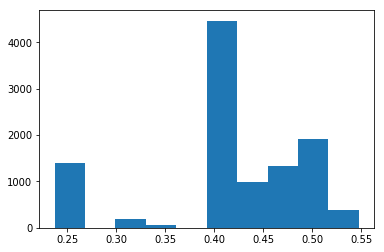

In [406]:
y_scores = cv.predict_proba(X_train)[:,1]
plt.hist(y_scores)
plt.show()

In [421]:
# Adjusting threshold #
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

# test set score #
y_scores = cv.predict_proba(X_train)[:,1]
y_pred = adjusted_classes(y_scores, 0.485)
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_train, y_pred, labels=None).ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')
test_accuracy = accuracy_score(y_train, y_pred)
print(f"Model accuracy: {test_accuracy*100:.2f}%")

True Negative: 6071
False Positive: 170
False Negative: 4284
True Positive: 216
Model accuracy: 58.53%


In [409]:
# test set score #
y_scores = cv.predict_proba(X_test)[:,1]
y_pred = adjusted_classes(y_scores, 0.485)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {test_accuracy*100:.2f}%")

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=None).ravel()
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')

Model accuracy: 57.27%
True Negative: 3356
False Positive: 806
False Negative: 2254
True Positive: 746


In [402]:
# replicating the pipeline without #
# using the pipeline itself to get #
# "labeled" feature importance     #

X_ohe = pd.get_dummies(X_test)
pipeline.fit(X_test, y_test)

fe = pipeline.named_steps["rf"].feature_importances_

feature_importance = zip(X_ohe.columns, fe)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")

Weight: 0.432 | Feature: creation_source_ORG_INVITE
Weight: 0.130 | Feature: enabled_for_marketing_drip
Weight: 0.075 | Feature: creation_source_PERSONAL_PROJECTS
Weight: 0.060 | Feature: creation_source_SIGNUP
Weight: 0.052 | Feature: creation_source_GUEST_INVITE
Weight: 0.029 | Feature: creation_source_SIGNUP_GOOGLE_AUTH
Weight: 0.027 | Feature: invited_by_user_id
Weight: 0.000 | Feature: opted_in_to_mailing_list
